Alvaro Viejo (100451677), Rodrigo Oliver (100451788), Oscar Montoya (100451858), Miguel Ángel Ponce (100451309)

In [1]:
from IPython import display
from IPython.core.display import Image

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [3]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2022

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Gaussian Processes

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level


In [230]:

data = pd.read_csv('diabetes.csv', header=0)
data.columns = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU','Y']
feature_names = data.columns # list with feature names
print("Feature names are")
for ii,fn  in enumerate(feature_names[:-1]):
    print("Column {0:d}: {1}".format(ii,fn))
X = data.values[:,:-1]
Y = data['Y'].values
print("")
print("Loaded {0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("Loaded {0:d} targets".format(len(Y)))


Feature names are
Column 0: AGE
Column 1: SEX
Column 2: BMI
Column 3: BP
Column 4: TC
Column 5: LDL
Column 6: HDL
Column 7: TCH
Column 8: LTG
Column 9: GLU

Loaded 442 observations with 10 columns
Loaded 442 targets


# Splitting into training and test set

Divide the data set into a training set with $2/3$ of the observations.

We use the train_test_split function of sklearn:

In [231]:
from sklearn.model_selection import train_test_split

train_test_prop = 2/3
X_train, X_test, y_train, y_test = train_test_split(X,Y, 
    train_size = train_test_prop, random_state=42)

# Check sizes are correct
print(f"{len(X_train)=}")
print(f"{len(X_test)=}")

len(X_train)=294
len(X_test)=148


# 1. Gaussian Process Regression initial result

Train a Gaussian Process with a composite kernel formed with the sum of:
  - RBF kernel:
     - `length_scale`= 1.5
     - `length_scale_bounds` [1e-2, 1e3]
  - White noise kernel:
     - `noise_level`=0.1
     - `noise_level_bounds` [1e-10, 1e6]
     
**Print the performance of the model in the test set.**

**Print the values of the kernel parameters after the GP optimization.**

In [232]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

noise_variance = .1

# instantiate the composite kernel
kernel_1 = 1.0 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10,1e6))

# instantiate the GP
gpr = GaussianProcessRegressor(kernel=kernel_1, random_state=42, n_restarts_optimizer=10)

# GaussianProcessRegressor(n_restarts_optimizer=10) this is in case we have the bad luck to get stuck and it makes it repeat the process

gpr.fit(X_train, y_train)
#y_mean, y_std = gpr.predict(X_test, return_std=True)

# Print results
print("Score in the test set:", gpr.score(X_test, y_test), "\n")
print(gpr.get_params())

print("\nOPTIMIZED KERNEL:",gpr.kernel_)


Score in the test set: 0.4665612298772024 

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 * RBF(length_scale=1.5), 'kernel__k2': WhiteKernel(noise_level=0.1), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': RBF(length_scale=1.5), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__length_scale': 1.5, 'kernel__k1__k2__length_scale_bounds': (0.01, 1000.0), 'kernel__k2__noise_level': 0.1, 'kernel__k2__noise_level_bounds': (1e-10, 1000000.0), 'kernel': 1**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.1), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42}

OPTIMIZED KERNEL: 316**2 * RBF(length_scale=171) + WhiteKernel(noise_level=3.22e+03)


c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### Your comments:

**Discuss about the differences between the kernel parameters before and after optimizing the GP.**

We can clearly see that the kernel has been optimized as the values of the parameters have changed. The kernel describes the covariance of the GP r.v..


# 2. Strategies to improve the initial result

In this assignment we are going to explore three strategies to improve this initial result

1. Scaling the data
2. Feature selection
3. Kernel design

## 2.1 Scaling the data

Repeat the experiment that produced the baseline result scaling the observations with a `MinMaxScaler` and evaluate the impact of this scaling in the performance of the GP. 

In [233]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
data_sca = pd.DataFrame(scaler.fit_transform(data), columns=feature_names)

# Separate predictors and target
X_sca = data_sca.iloc[:, :-1]
Y_sca = data_sca.iloc[:, -1]

X_train_sca, X_test_sca, y_train_sca, y_test_sca = train_test_split(
    X_sca, Y_sca, train_size=2/3, random_state=42)

# Print the scaled
print(data_sca.head())

        AGE  SEX       BMI        BP        TC       LDL       HDL       TCH  \
0  0.666667  1.0  0.582645  0.549296  0.294118  0.256972  0.207792  0.282087   
1  0.483333  0.0  0.148760  0.352113  0.421569  0.306773  0.623377  0.141044   
2  0.883333  1.0  0.516529  0.436620  0.289216  0.258964  0.246753  0.282087   
3  0.083333  0.0  0.301653  0.309859  0.495098  0.447211  0.233766  0.423131   
4  0.516667  0.0  0.206612  0.549296  0.465686  0.417331  0.389610  0.282087   

        LTG       GLU         Y  
0  0.562217  0.439394  0.392523  
1  0.222437  0.166667  0.155763  
2  0.496578  0.409091  0.361371  
3  0.572923  0.469697  0.563863  
4  0.362385  0.333333  0.342679  


In [234]:
# Fit the scaled data onto the Gaussian process with optimized kernel
gpr.fit(X_train_sca, y_train_sca)
# Get the prediction results
y_mean, y_std = gpr.predict(X_test_sca, return_std=True)

# Print the results
print("Score in the test set:", gpr.score(X_test_sca, y_test_sca), "\n")
print(gpr.get_params())

print("\nOPTIMIZED KERNEL:",gpr.kernel_)

Score in the test set: 0.5267109067080147 

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2 * RBF(length_scale=1.5), 'kernel__k2': WhiteKernel(noise_level=0.1), 'kernel__k1__k1': 1**2, 'kernel__k1__k2': RBF(length_scale=1.5), 'kernel__k1__k1__constant_value': 1.0, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__length_scale': 1.5, 'kernel__k1__k2__length_scale_bounds': (0.01, 1000.0), 'kernel__k2__noise_level': 0.1, 'kernel__k2__noise_level_bounds': (1e-10, 1000000.0), 'kernel': 1**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.1), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42}

OPTIMIZED KERNEL: 0.796**2 * RBF(length_scale=3.4) + WhiteKernel(noise_level=0.0295)


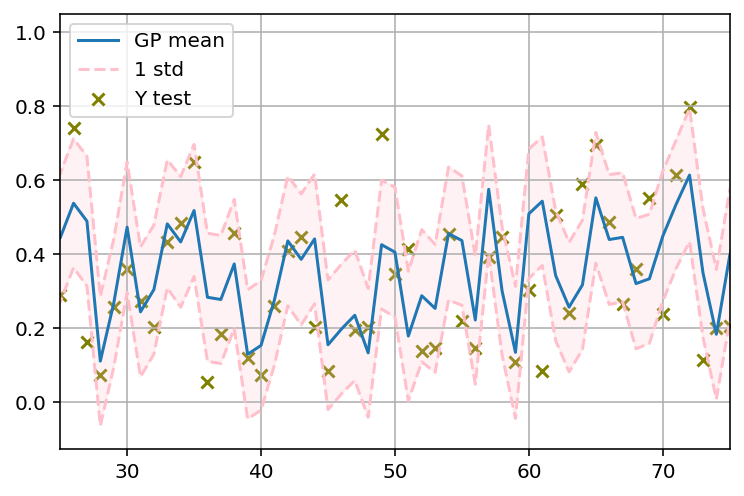

In [235]:
# Create a common x axis
x_range = range(len(y_mean))

# plot the information
plt.plot(x_range, y_mean, label="GP mean")
plt.plot(x_range, y_mean-y_std, color="pink", linestyle="--", label="1 std")
plt.plot(x_range, y_mean+y_std, color="pink", linestyle="--")
plt.scatter(x_range, y_test_sca, color="olive", marker="x", label="Y test")
plt.fill_between(x_range, y1=y_mean-y_std, y2=y_mean +

plt.xlim((0, 50))
plt.xlabel("Observation Index")
plt.ylabel("Value")
plt.title

                 y_std, color="pink", alpha=0.20)
plt.legend()
plt.grid()


### Your comments:

**Did scaling improve the accuracy of the GP?**

**Did scaling affect to the final value of the kernel parameters after the optimization?**

## 2.2 Feature selection

The goal in this strategy is to study
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

We will explore two strategies to perform the feature selection

1. Random Forests property `feature_importances_`.  

2. GP with an ARD kernel



### 2.2.1 Random Forests `feature_importances_`

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these test, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.


In the following cell write code that
 1. Train a Random Forest Regressor with its hyperparameters selected by cross-validation within the following  ranges
  - number of trees: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per node: 5, 10, 20, 50
  
 2. Print the score in the test set  of the Random Forest fitted with the best set of hyperparameters
 
 3. Print the value of `feature_importances_` for each feature in the data set
 
 4. Sort the features in order of decreasing importance in an array called `random_forest_order`
 
 

We will use the GridSearchCV for the cross-validation of the best hyperparameters:

In [236]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Parameter Grid

hypams = {
    "n_estimators": [10,20,50,100,200,500,1000],
    "max_leaf_nodes": [5,10,20,50]
}
#Model
rforest_reg = RandomForestRegressor()
#grid search with cv:
grid_rf_reg = GridSearchCV(rforest_reg, hypams)

#fit
grid_rf_reg.fit(X_train, y_train)

#Evaluation with test set
test_error_gridrf_reg =  grid_rf_reg.score(X_test,y_test)

print("Test Set Score with best parameters")
print(np.round(test_error_gridrf_reg,3))
print("Best parameters")
print(grid_rf_reg.best_params_)
best_max_leaf=grid_rf_reg.best_params_['max_leaf_nodes']
best_n_estimators=grid_rf_reg.best_params_['n_estimators']

rforest_reg_importance = RandomForestRegressor(n_estimators=best_n_estimators, max_leaf_nodes=best_max_leaf).fit(X_train, y_train).feature_importances_
print("Feature importance: \n", rforest_reg_importance)


Test Set Score with best parameters
0.46
Best parameters
{'max_leaf_nodes': 20, 'n_estimators': 50}
Feature importance: 
 [0.04513156 0.00641518 0.41781305 0.12550444 0.04210964 0.03991253
 0.05454558 0.01334782 0.20707316 0.04814704]


Importances sorted:

In [237]:
rforest_reg_importance_s=np.sort(rforest_reg_importance)
rforest_reg_importance_sort=[]
for i in range(len(rforest_reg_importance)):
    rforest_reg_importance_sort.insert(0, rforest_reg_importance_s[i])
print(rforest_reg_importance_sort)


[0.4178130529256137, 0.2070731633999978, 0.12550444158905488, 0.054545579664199983, 0.048147041892256076, 0.04513155955272344, 0.042109638795853284, 0.03991252598216085, 0.013347819628882674, 0.006415176569257299]


### Your comments:

**Did RF perform in the test set better than GP?**

**What are the more relevant features according to RF?**

**Are there significant differences in relevance among the features?**



In the next cell write code that implements a `for loop` that in each iteration trains a GP with the settings of Section 1 but increasing the number of features in the ordering suggested by `random_forest_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

First we need to create a list for every feature so we can add one by one by importance:

In [238]:
features={}
rforest_reg_importance=rforest_reg_importance.tolist()
for i in range(len(rforest_reg_importance_sort)):
    features[str(rforest_reg_importance.index(rforest_reg_importance_sort[i]))]=rforest_reg_importance_sort[i]


In [239]:
print(features)
list_features=list(features.keys())

{'2': 0.4178130529256137, '8': 0.2070731633999978, '3': 0.12550444158905488, '6': 0.054545579664199983, '9': 0.048147041892256076, '0': 0.04513155955272344, '4': 0.042109638795853284, '5': 0.03991252598216085, '7': 0.013347819628882674, '1': 0.006415176569257299}


In [240]:
cols=[]
scores=[]
columns_used=[]
print(type(cols))
for i in range(len(features)):
    cols.append(int(list_features[i]))

    gpr.fit(X_train[:,cols], y_train)
    y_mean, y_std = gpr.predict(X_test[:, cols], return_std=True)

    gpr_score=gpr.score(X_test[:,cols], y_test)
    scores.append(gpr_score)
    columns_used.append(i)
    print("Columns Used:", cols)
    print("Score in the test set:", gpr_score, "\n")
    #print(gpr.get_params()) output too long

    print("\nOPTIMIZED KERNEL:",gpr.kernel_, "\n\n")

<class 'list'>
Columns Used: [2]
Score in the test set: 0.3166184649527475 


OPTIMIZED KERNEL: 311**2 * RBF(length_scale=38.7) + WhiteKernel(noise_level=3.93e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8]
Score in the test set: 0.48728385444261946 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=15.8) + WhiteKernel(noise_level=3.44e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3]
Score in the test set: 0.43696179669407553 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=43.4) + WhiteKernel(noise_level=3.32e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6]
Score in the test set: 0.41423636131538366 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=85.3) + WhiteKernel(noise_level=3.28e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9]
Score in the test set: 0.42116738042820523 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=106) + WhiteKernel(noise_level=3.31e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9, 0]
Score in the test set: 0.4281543125712586 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=115) + WhiteKernel(noise_level=3.28e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9, 0, 4]
Score in the test set: 0.41068437177057326 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=155) + WhiteKernel(noise_level=3.34e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9, 0, 4, 5]
Score in the test set: 0.46431179717031557 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=173) + WhiteKernel(noise_level=3.23e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9, 0, 4, 5, 7]
Score in the test set: 0.46439674481155757 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=173) + WhiteKernel(noise_level=3.23e+03) 


Columns Used: [2, 8, 3, 6, 9, 0, 4, 5, 7, 1]
Score in the test set: 0.4665612298771902 


OPTIMIZED KERNEL: 316**2 * RBF(length_scale=171) + WhiteKernel(noise_level=3.22e+03) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[0.3166184649527475, 0.48728385444261946, 0.43696179669407553, 0.41423636131538366, 0.42116738042820523, 0.4281543125712586, 0.41068437177057326, 0.46431179717031557, 0.46439674481155757, 0.4665612298771902]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


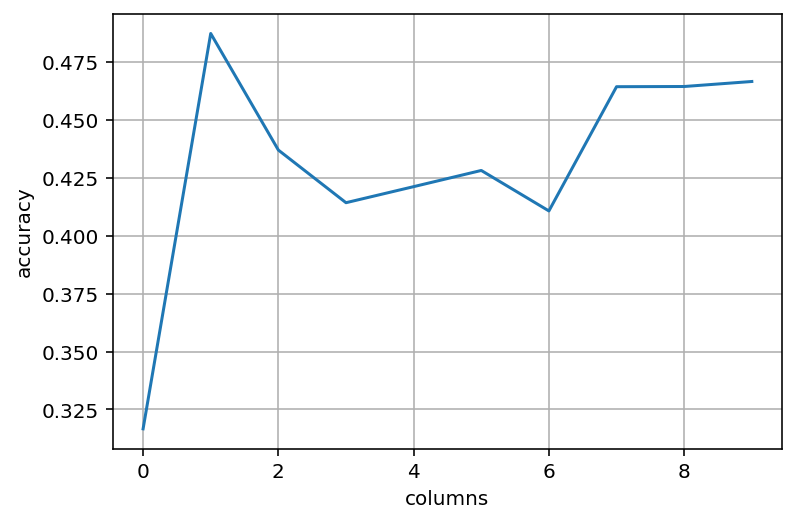

In [241]:
print(scores)
print(columns_used)

plt.plot(np.array(columns_used), np.array(scores))
plt.ylabel('accuracy')
plt.xlabel('columns')
plt.grid()

### Your comments:

**What is the best number of features to model the problem?**

**Does removing features improve the performance of RF?**

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**



### 2.2.2 GP with an ARD kernel

The fitting of a GP endowed with an anisotropic RBF kernel obtains a different value of the `length_scale` for each variable.

**Relate the length scale of each variable with its relevance in the predictive function**

Hint: Consider how does the output of the predictive function changes as the value of a certain variable $x_k$ changes depending on $l_k^2$.

In the next cell write code that fits a GP with an ARD kernel. 

**Print the lengthscale value of each feature after the kernel has been optimized** Hint, learn to use `kernel_get_params()`.** 

**Sort the features in order of decreasing importance in an array called `ARD_order`**

**Print the score in the test set  of the GP with ARD kernel**

In order to use an anisotropic kernel, the length_scale value of the parameters must be now an array, in which each dimension of the length defines the length scale of the respective feature dimension. First we will make the model and it's fit and after that we will talk about the relevance of the length scale and do the ARD_order.

In [242]:
from sklearn.linear_model import ARDRegression

# define ARD kernel
kernel_2 = RBF(length_scale =np.ones(10)*1.5 , length_scale_bounds=(1e-2, 1e5))

# instantiate the GP
gpr_2 = GaussianProcessRegressor(kernel=kernel_2, random_state=42, n_restarts_optimizer=10)
gpr_2.fit(X_train, y_train)
y_mean, y_std = gpr_2.predict(X_test, return_std=True)


print(gpr_2.kernel_)
print("Score in the test set:", gpr_2.score(X_test, y_test), "\n")
print(gpr_2.get_params())




RBF(length_scale=[9.99e+04, 1.06, 7.14, 12.7, 10.4, 4.24e+04, 2.91, 4.69, 0.824, 1e+05])
Score in the test set: -0.5771264857218248 

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'kernel__length_scale_bounds': (0.01, 100000.0), 'kernel': RBF(length_scale=[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]), 'n_restarts_optimizer': 10, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 42}


So, before doing the ARD_order we will relate the length scale to the importance of each feature for the model and the predictive function. For that we will print again the final kernel:



In [243]:
print(gpr_2.kernel_)

RBF(length_scale=[9.99e+04, 1.06, 7.14, 12.7, 10.4, 4.24e+04, 2.91, 4.69, 0.824, 1e+05])


As we can see we have bigger and smaller values, what do they mean? An small lengthscale means the function values can change quickly  while large ones characterize function features that vary less or slower. 

So, for characterizing which is more important we could say that those with LOWER lengthscales will have a bigger influence on the model as are those ones which will vary more, and in the other hand, those with higher values are features varying less so they can be almost irrelevant for the model.

In fact here we can see that columns 2 and 9 have the lower values, meaning they are more relevant, and if we compare this with the last section selection of features some similarities can be obtained.

Now let's put them in order:

In [244]:
#WE GET THE FEATURES IN ORDER
params=gpr_2.kernel_.get_params()["length_scale"]
params=params.tolist()
params_s=np.sort(params)
params_sort=[]
for i in range(len(params_s)):
    params_sort.append(params_s[i])
ARD_order={}
for i in range(len(params_s)):
    ARD_order[str(params.index(params_sort[i]))]=params_sort[i]
    
#ARD ORDER
print(ARD_order)

{'8': 0.8236717136886791, '1': 1.0565176661802502, '6': 2.9110099793832354, '7': 4.692766254931119, '2': 7.1365101118146095, '4': 10.43112561354318, '3': 12.672145090763442, '5': 42428.8568838139, '0': 99917.09333889124, '9': 99950.48452157118}


In the next cell write code that implements a `for loop` that in each iteration trains a GP with an ARD kernel but increasing the number of features in the ordering suggested by `ARD_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

In [245]:
cols=[]
scores=[]
columns_used=[]
print(type(cols))
for i in range(len(features)):
    cols.append(int(list_features[i]))
    
    # define ARD kernel
    kernel_3 = RBF(length_scale =np.ones(i+1)*1.5 , length_scale_bounds=(1e-2, 1e5))

    # instantiate the GP
    gpr_3 = GaussianProcessRegressor(kernel=kernel_3, random_state=42, n_restarts_optimizer=10)

    gpr_3.fit(X_train[:,cols], y_train)
    y_mean, y_std = gpr_3.predict(X_test[:, cols], return_std=True)

    gpr_3_score=gpr_3.score(X_test[:,cols], y_test)
    scores.append(gpr_3_score)
    columns_used.append(i)
    print("Columns Used:", cols)
    print("Score in the test set:", gpr_3_score, "\n")
    #print(gpr.get_params()) output too long

    print("\nOPTIMIZED KERNEL:",gpr_3.kernel_, "\n\n")

<class 'list'>


c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Columns Used: [2]
Score in the test set: -0.7633842859856375 


OPTIMIZED KERNEL: RBF(length_scale=0.0249) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Columns Used: [2, 8]
Score in the test set: -3.036402008485174 


OPTIMIZED KERNEL: RBF(length_scale=[0.124, 0.124]) 


Columns Used: [2, 8, 3]
Score in the test set: -2.2758128711914356 


OPTIMIZED KERNEL: RBF(length_scale=[0.236, 0.503, 1.69]) 


Columns Used: [2, 8, 3, 6]
Score in the test set: -1.3267299554443137 


OPTIMIZED KERNEL: RBF(length_scale=[8.83, 0.0386, 8.05, 4.26]) 


Columns Used: [2, 8, 3, 6, 9]
Score in the test set: -0.6439265332380038 


OPTIMIZED KERNEL: RBF(length_scale=[4.1, 0.619, 15.7, 15, 0.923]) 


Columns Used: [2, 8, 3, 6, 9, 0]
Score in the test set: -0.3480217228341367 


OPTIMIZED KERNEL: RBF(length_scale=[4.32, 0.537, 18.3, 3.64, 21.9, 5.5]) 


Columns Used: [2, 8, 3, 6, 9, 0, 4]
Score in the test set: -0.17775802151015374 


OPTIMIZED KERNEL: RBF(length_scale=[6.04, 0.785, 17.6, 2.89, 29.1, 9.05, 44]) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9, 0, 4, 5]
Score in the test set: -0.796528885576953 


OPTIMIZED KERNEL: RBF(length_scale=[6.13, 0.908, 14.8, 3.25, 1e+05, 1e+05, 4.87, 8.91e+04]) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Columns Used: [2, 8, 3, 6, 9, 0, 4, 5, 7]
Score in the test set: -0.7555980324112461 


OPTIMIZED KERNEL: RBF(length_scale=[4.65, 0.909, 16.9, 4.27, 1e+05, 1e+05, 4.81, 9.58e+04, 1.43]) 


Columns Used: [2, 8, 3, 6, 9, 0, 4, 5, 7, 1]
Score in the test set: -0.45166085344827067 


OPTIMIZED KERNEL: RBF(length_scale=[5.01, 0.946, 10.7, 13.9, 7.5, 16.3, 1e+05, 38, 3.5, 0.0211]) 




c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[-0.7633842859856375, -3.036402008485174, -2.2758128711914356, -1.3267299554443137, -0.6439265332380038, -0.3480217228341367, -0.17775802151015374, -0.796528885576953, -0.7555980324112461, -0.45166085344827067]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


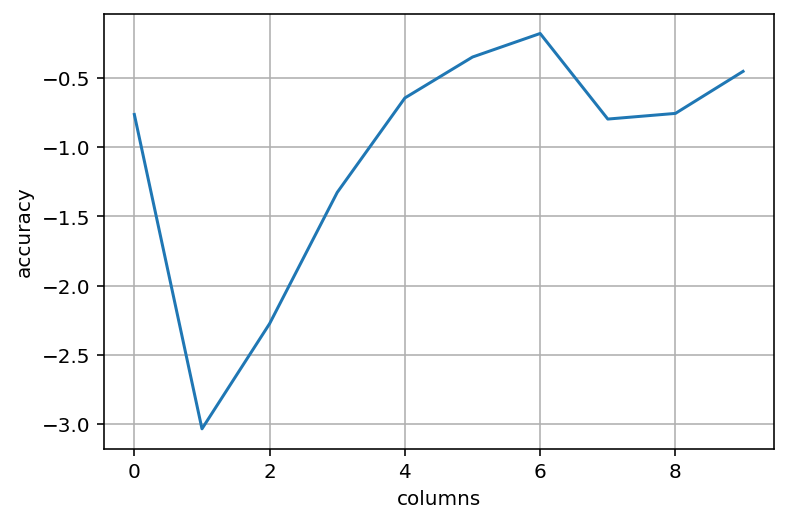

In [246]:
print(scores)
print(columns_used)

plt.plot(np.array(columns_used), np.array(scores))
plt.ylabel('accuracy')
plt.xlabel('columns')
plt.grid()

### Your comments:

**What is the best number of features to model the problem according to the ARD kernel?**

**Does removing features improve the performance of RF?**

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**

**How does the feature selection suggested by the ARD kernel compare with that suggested by random forest?**

# 4. Exploring sophisticate kernels for the GP

The greatest potentiality of GPs are the exploration of different kernels that capture the geometry of the inputs. 

Besides, the essential kernels can be combined into more sophisticate ones using the addition and multiplication operations.

And the most interesting feature, the GP implementation is able to optimize the parameters of the kernel maximizing the likelihood of the observations, what saves the crossvalidation step for optimizing parameters.

Read the [section 1.7.5 of this site](https://scikit-learn.org/stable/modules/gaussian_process.html) to learn the different kernels that are implemented in the scikit learn distribution of Gaussian Processes.

In this section check at least ten different kernel configurations and evaluate if they improve the kernel evaluated in section 1. Remember this kernel was

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Within the kernel combinations to explore you can include:
1. Add a `ConstantKernel` to $\kappa_1(\mathbf x_i, \mathbf x_j)$

2. Replace $\kappa_r(\mathbf x_i, \mathbf x_j)$ by an anisotropic RBF in $\kappa_1(\mathbf x_i, \mathbf x_j)$. 

3. Individual kernels presented in the lecture

4. Addition of several kernels

5. Multiplication of several kernels

6. Use your imagination!

We will use the different kernel combinations to characterize how difficult is the problem at hand in terms of how difficult is to find out a kernel that achieves the best possible result in the test set.

For this purpose:
1. Group in a same array all the scores in the **test set** achieved by all the kernel combinations that you explore in this section. Consider carrying out this exploration in a programatic fashion.

2. Discuss about the range of test accuracies that can be reached with GPs when the kernel is more carefully designed. Depending on the number of different kernels explored you might consider adding to your discussion
- minimum, maximum, mean values
- standard deviations
- percentiles
- histogram

In [247]:
#############
#           #
# YOUR CODE #
#           #
#############


# Items for discussion
- Which strategy turned out to be the best in terms of increasing the performance of the GP? 
- Did this strategy performed significantly better than the others?
- Kernel design pushes the GP model further into the **black box method** region, what is the price you pay for sticking to the more interpretable ARD kernel in terms of accuracy? 